# 이미지 분류 시스템 구축

## 강아지 품종 (치와와, 요크셔테리어, 진돗개, 셰퍼드) 분류
<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/27-1.png" style="max-width: 60%; height: auto;"><p>


# Training Data
<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/27-2.png" style="max-width: 60%; height: auto;"><p>


# Transfer Learning
<img src = "http://cmseng.skku.edu/CMSLecture/ML/img/27-3.png" style="max-width: 60%; height: auto;"><p>


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/ML_Python')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 12 15:33:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Google Drive 마운트

# Training data download

- #### [training data download: [dog_image.zip]](http://cmseng.skku.edu/CMSLecture/ML/img/dog_image.zip)

## root dir 설정 (Colab 이외의 환경에서는 root dir 을 변경해주면 된다) 

In [7]:
root_dir = '/content/gdrive/MyDrive/Colab Notebooks/ML_Python'

In [8]:
import os
import shutil

if os.path.exists( os.path.join(root_dir, 'dog_image') ):
    shutil.rmtree( os.path.join(root_dir, 'dog_image') )

In [9]:
import zipfile

with zipfile.ZipFile(os.path.join(root_dir, 'dog_image.zip'), 'r') as target_file:

    target_file.extractall(os.path.join(root_dir, 'dog_image'))

In [10]:
import os
import shutil

if not os.path.exists(os.path.join(root_dir, 'dog_image/test')):
    os.mkdir(os.path.join(root_dir, 'dog_image/test'))

if not os.path.exists(os.path.join(root_dir, 'dog_image/test_image_files')):
    os.mkdir(os.path.join(root_dir, 'dog_image/test_image_files'))

In [11]:
# 데이터 전체 개수 확인

import os
import glob

label_name_list = os.listdir(os.path.join(root_dir, 'dog_image/train/'))

print('total label nums = ', len(label_name_list))
print('=================================================')
print(label_name_list)

total label nums =  4
['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']


# 먼저 train -> test 디렉토리로 ratio 만큼 move

In [12]:
import os
import glob
import shutil

ratio = 0.1    # train : test = 90 : 10

src_root_dir = os.path.join(root_dir,'dog_image/train/')
dst_root_dir = os.path.join(root_dir, 'dog_image/test/')

label_name_list = os.listdir(src_root_dir)

for label_name in label_name_list:   # test 디렉토리에 label 디렉토리 생성
    dst_label_name_dir = dst_root_dir + label_name

    if not os.path.exists(dst_label_name_dir):
        os.mkdir(dst_label_name_dir)

for label_name in label_name_list:    # 파일 move src dir => dst dir
    train_image_file_list = glob.glob(src_root_dir+label_name+'/*')
    split_num = int(ratio*len(train_image_file_list))
    test_image_file_list = train_image_file_list[0:split_num]

    for image_file in test_image_file_list:
        shutil.move(image_file, dst_root_dir+label_name)    # move

In [13]:
# train : test 데이터 비율 확인

src_root_dir = os.path.join(root_dir,'dog_image/train/')
dst_root_dir = os.path.join(root_dir, 'dog_image/test/')

train_label_name_list = os.listdir(src_root_dir)
test_label_name_list = os.listdir(src_root_dir)

train_label_name_list.sort()
test_label_name_list.sort()

if train_label_name_list != test_label_name_list:
    print('fatal error !!!!')
else:
    print(len(train_label_name_list), len(test_label_name_list))

# 데이터 개수 확인

for label_name in train_label_name_list:

    train_data_nums = len(os.listdir(src_root_dir+label_name))
    test_data_nums = len(os.listdir(dst_root_dir+label_name))

    print('train => ', label_name, train_data_nums, ' , test => ', label_name, test_data_nums)
    print('=======================================================')

4 4
train =>  chihuahua 329  , test =>  chihuahua 36
train =>  jindo_dog 324  , test =>  jindo_dog 36
train =>  shepherd 339  , test =>  shepherd 37
train =>  yorkshire_terrier 342  , test =>  yorkshire_terrier 37


# test -> test_image_files 디렉토리로 copy

In [15]:
import os
import glob
import shutil

src_root_dir = os.path.join(root_dir, 'dog_image/test/')
dst_root_dir = os.path.join(root_dir, 'dog_image/test_image_files/')

label_name_list = os.listdir(src_root_dir)

for label_name in label_name_list:  # 파일 copy src dir => dst dir
    image_file_list = glob.glob(src_root_dir+label_name+'/*')
    print('total [%s] image file nums => [%s]' % (label_name ,len(image_file_list)))

    copy_nums = 0

    for image_file in image_file_list:
        shutil.copy(image_file, dst_root_dir)    # copy
        copy_nums = copy_nums + 1

    print('total copy nums => ', copy_nums)

total [chihuahua] image file nums => [36]
total copy nums =>  36
total [jindo_dog] image file nums => [36]
total copy nums =>  36
total [shepherd] image file nums => [37]
total copy nums =>  37
total [yorkshire_terrier] image file nums => [37]
total copy nums =>  37


# ImageDataGenerator 설정

In [16]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_dir = os.path.join(root_dir, 'dog_image/train/')
validation_dir = os.path.join(root_dir, 'dog_image/train/')
test_dir = os.path.join(root_dir, 'dog_image/test/')

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                    validation_split=0.15)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [18]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, color_mode='rgb',
                                                class_mode='sparse', subset = 'training',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=16, color_mode='rgb',
                                                          class_mode='sparse', subset = 'validation',
                                                          target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 1136 images belonging to 4 classes.
Found 198 images belonging to 4 classes.


In [19]:
print(train_generator.class_indices)

{'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}


# Transfer Learning base 모델 구축

In [20]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

17225924/17225924 [==============================] - 0s 0us/step


In [21]:
model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4834660 (18.44 MB)
Trainable params: 4812772 (18.36 MB)
Non-trainable params: 21888 (85.50 KB)
_____________

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(train_generator, validation_data=validation_generator,
                 epochs=50, callbacks=[earlystopping])

Epoch 1/50
71/71 [==============================] - 42s 315ms/step - loss: 1.3959 - accuracy: 0.4771 - val_loss: 0.6831 - val_accuracy: 0.7172
Epoch 2/50
71/71 [==============================] - 20s 278ms/step - loss: 0.8113 - accuracy: 0.6840 - val_loss: 0.3810 - val_accuracy: 0.8283
Epoch 3/50
71/71 [==============================] - 20s 278ms/step - loss: 0.5655 - accuracy: 0.7826 - val_loss: 0.2655 - val_accuracy: 0.9141
Epoch 4/50
71/71 [==============================] - 22s 301ms/step - loss: 0.4805 - accuracy: 0.8204 - val_loss: 0.2215 - val_accuracy: 0.8990
Epoch 5/50
71/71 [==============================] - 20s 282ms/step - loss: 0.4114 - accuracy: 0.8433 - val_loss: 0.1769 - val_accuracy: 0.9394
Epoch 6/50
71/71 [==============================] - 21s 289ms/step - loss: 0.3736 - accuracy: 0.8583 - val_loss: 0.1665 - val_accuracy: 0.9444
Epoch 7/50
71/71 [==============================] - 21s 294ms/step - loss: 0.3161 - accuracy: 0.8900 - val_loss: 0.1873 - val_accuracy: 0.9343

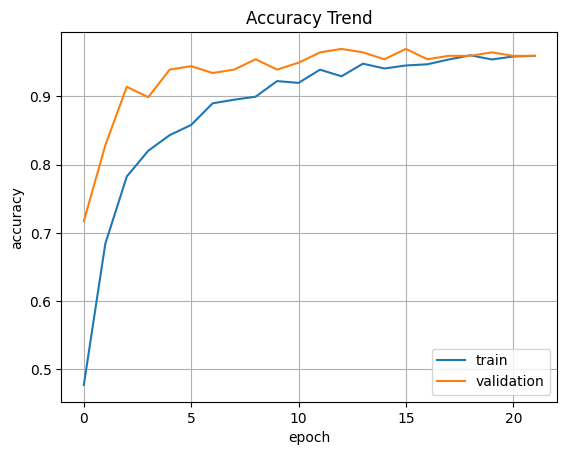

In [24]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

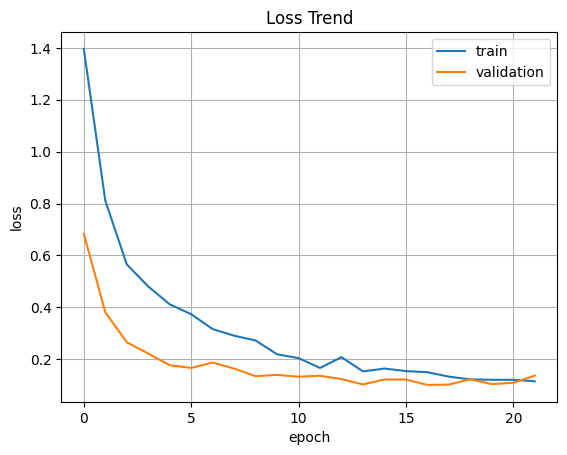

In [25]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=32, color_mode='rgb',
                                              class_mode='sparse', target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 146 images belonging to 4 classes.


In [28]:
model.evaluate(test_generator)

5/5 [==============================] - 2s 200ms/step - loss: 0.0674 - accuracy: 0.9726


[0.06737156212329865, 0.9726027250289917]

In [33]:
import random
import os
import numpy as np
import cv2
import glob

label_dict = {'chihuahua': 0, 'jindo_dog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}

test_image_files_list = glob.glob(root_dir+ '/dog_image/test_image_files/*.jpg')

random.shuffle(test_image_files_list)

test_num = 16
test_image_files = test_image_files_list[:test_num]  # 태스트 파일이름은 정답.숫자.jpg

label_list = []

for i in range(len(test_image_files)):
    label = test_image_files[i].split('/')[-1].split('.')[0].strip()
    label_list.append(label_dict[label])

src_img_list = []

for i in range(len(test_image_files)):
    src_img = cv2.imread(test_image_files[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    src_img_list.append(src_img)

# 4차원 텐서  변환
src_img_array = np.array(src_img_list)
label_array = np.array(label_list)

print(src_img_array.shape, label_array.shape)
print(label_array)

(16, 224, 224, 3) (16,)
[3 1 0 3 2 2 2 1 1 0 3 3 1 3 0 3]


In [34]:
pred = model.predict(src_img_array)
print(pred.shape)

1/1 [==============================] - 0s 26ms/step
(16, 4)


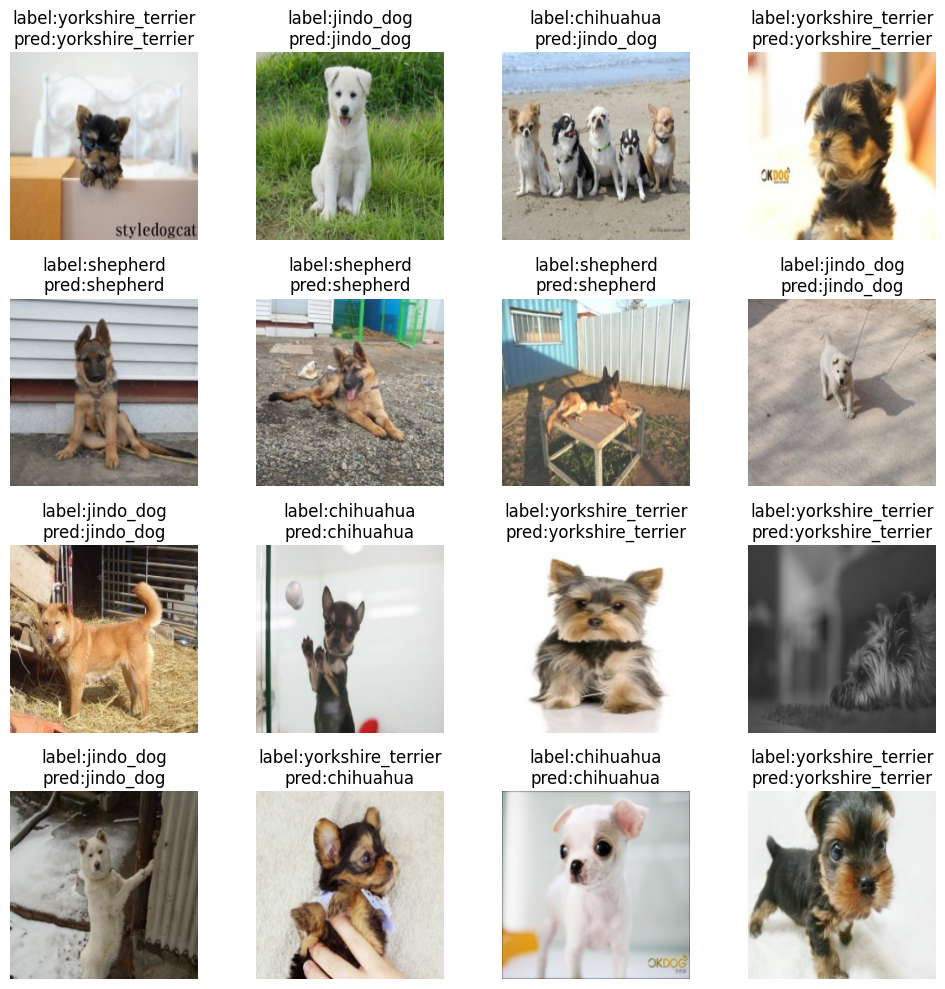

In [35]:
import matplotlib.pyplot as plt

class_names = ['chihuahua', 'jindo_dog', 'shepherd', 'yorkshire_terrier']

plt.figure(figsize=(10,10))

for pos in range(len(pred)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')

    label_str = class_names[label_array[pos]]
    pred_str = class_names[np.argmax(pred[pos])]

    plt.title('label:' + label_str + '\npred:' + pred_str)

    plt.imshow(src_img_array[pos])

plt.tight_layout()
plt.show()